In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CANDIDATES = {'dems':['H. CLINTON', 'B. SANDERS'], 
              'reps':['D. TRUMP','T. CRUZ']}#,'M. RUBIO'

In [3]:
def prepareCountyInfo(party):
    # party = 'dems' or 'reps'
    
    source = pd.read_csv(r'.\stitched_data\county_%s.csv' % (party), index_col = 0)
    res = pd.get_dummies(source['primary_type'])
    source = pd.concat([source, res], axis = 1)

    #candidates = county_dems[['1st','2nd','3rd']].as_matrix().flatten()
    #candidates = set(candidates)
    colNames = source.columns.values
    global X_names
    X_names = colNames[22:]
    #print X_names
    
    
    # Can add more if you think necessary.
    
    for candidate in cdd_thisParty:
        source[candidate] = np.nan
        #source['Sanders'] = np.nan
        for idx, row in source.iterrows():
            if row['1st'] == candidate:
                source.loc[idx, candidate] = row['edge1']
            elif row['2nd'] == candidate:
                source.loc[idx, candidate] = row['edge2']
            elif row['3rd'] == candidate:
                source.loc[idx, candidate] = row['edge3']
    return source

In [4]:
from sklearn import linear_model
def runRegression_one(trainset,testset, model):
    for cdd in cdd_thisParty:       
        trainset = trainset[~trainset[cdd].isnull()]
        testset = testset[~testset[cdd].isnull()]
  
    trainset = trainset.fillna(trainset.mean())
    testset = testset.fillna(testset.mean())
    test_state = testset['state'][~testset['state'].duplicated()]
    reg = model.fit(trainset[X_names], trainset[cdd_thisParty])
    #fit_score = model.score(trainset[X_names], trainset[cdd_thisParty])
    #print fit_score
    score_series = {}
    for this_state in test_state.values:
        this_test = testset.loc[testset['state']==this_state]
        if len(this_test)<=1:
            score_series[this_state] = [None]
        else:
            pred_edge = model.predict(this_test[X_names])
            pred_score = model.score(this_test[X_names], this_test[cdd_thisParty])
            score_series[this_state] = [pred_score]
    score_series = pd.DataFrame(score_series, index = ['Score']).T
    return score_series

In [5]:
#Create samples
def getBigDayList(party):
    states_info = pd.read_csv(r'.\stitched_data\states_%s.csv' % (party), parse_dates = ['Date'])
    bigday_list = states_info[['Date','State']].sort_values('Date')
    bigday_list = bigday_list[~bigday_list['State'].duplicated(keep = 'last')]
    bigday = bigday_list[~bigday_list['Date'].duplicated()]
    bigday = bigday.loc[bigday['Date']>=datetime(2016,3, 1), 'Date'].tolist()
    return bigday_list, bigday

def runRegression_all(source, bigday_list, bigday, model1):
    nodata_list = [x for x in bigday_list['State'].values if len(source.loc[source['state']==x])<=1]
    bigday_list = bigday_list[~bigday_list['State'].isin(nodata_list)]
    for idx in range(len(bigday)-1):
        train_state = bigday_list.loc[bigday_list['Date']<=bigday[idx], 'State']
        test_state  = bigday_list.loc[bigday_list['Date']> bigday[idx] ,'State']
        trainset = source[source['state'].isin(train_state.values)]
        testset = source[source['state'].isin(test_state.values)]
        score_series = runRegression_one(trainset, testset,model1)
        score_series = bigday_list.merge(score_series, how = 'outer', left_on = 'State', right_index = True)
        if idx ==0:
            score_result = score_series
        else:
            score_result['Score'+str(idx+1)] = score_series['Score']

    score_result = score_result[score_result['Date']> datetime(2016,3,1)]  
    score_result = score_result.set_index(['Date','State'])
    return score_result


In [6]:
# Put them all together
def mainRegFunc(party, model1):
    global cdd_thisParty
    cdd_thisParty = CANDIDATES[party]    
    # As there are so many candidates, for simplicity I just run it for these candidates as they have the most data.
    
    source = prepareCountyInfo(party)
    bigday_list, bigday = getBigDayList(party)
    score_result = runRegression_all(source, bigday_list, bigday, model1)
    return score_result

In [7]:
# for one model
def useOneModel(model):
    score = mainRegFunc('dems', model)
    score = score.reset_index(level=['Date'], drop = True)
    #score.plot(figsize = (12,4))
    score_T = score.T
    fig, axes = plt.subplots(8, 4, figsize = (16, 32))
    for idx, col in enumerate(score_T):
        left = int(idx/4)
        right = idx - int(idx/4)*4
        score_T[col].plot(ax = axes[left, right], style = 'o-')
        axes[left,right].set_title(col + ': '+ str(round(score_T[col].max(),2)))
        plt.tight_layout()
    plt.show()
    
    MODEL = linear_model.Ridge(alpha = 0, normalize = True)
    score = mainRegFunc('reps', model)
    score = score.reset_index(level=['Date'], drop = True)
    #score.plot(figsize = (12,4))
    score_T = score.T
    fig, axes = plt.subplots(8, 4, figsize = (16, 32))
    for idx, col in enumerate(score_T):
        left = int(idx/4)
        right = idx - int(idx/4)*4
        score_T[col].plot(ax = axes[left, right], style = 'o-')
        axes[left,right].set_title(col + ': '+ str(round(score_T[col].max(),2)))
        plt.tight_layout()
    plt.show()

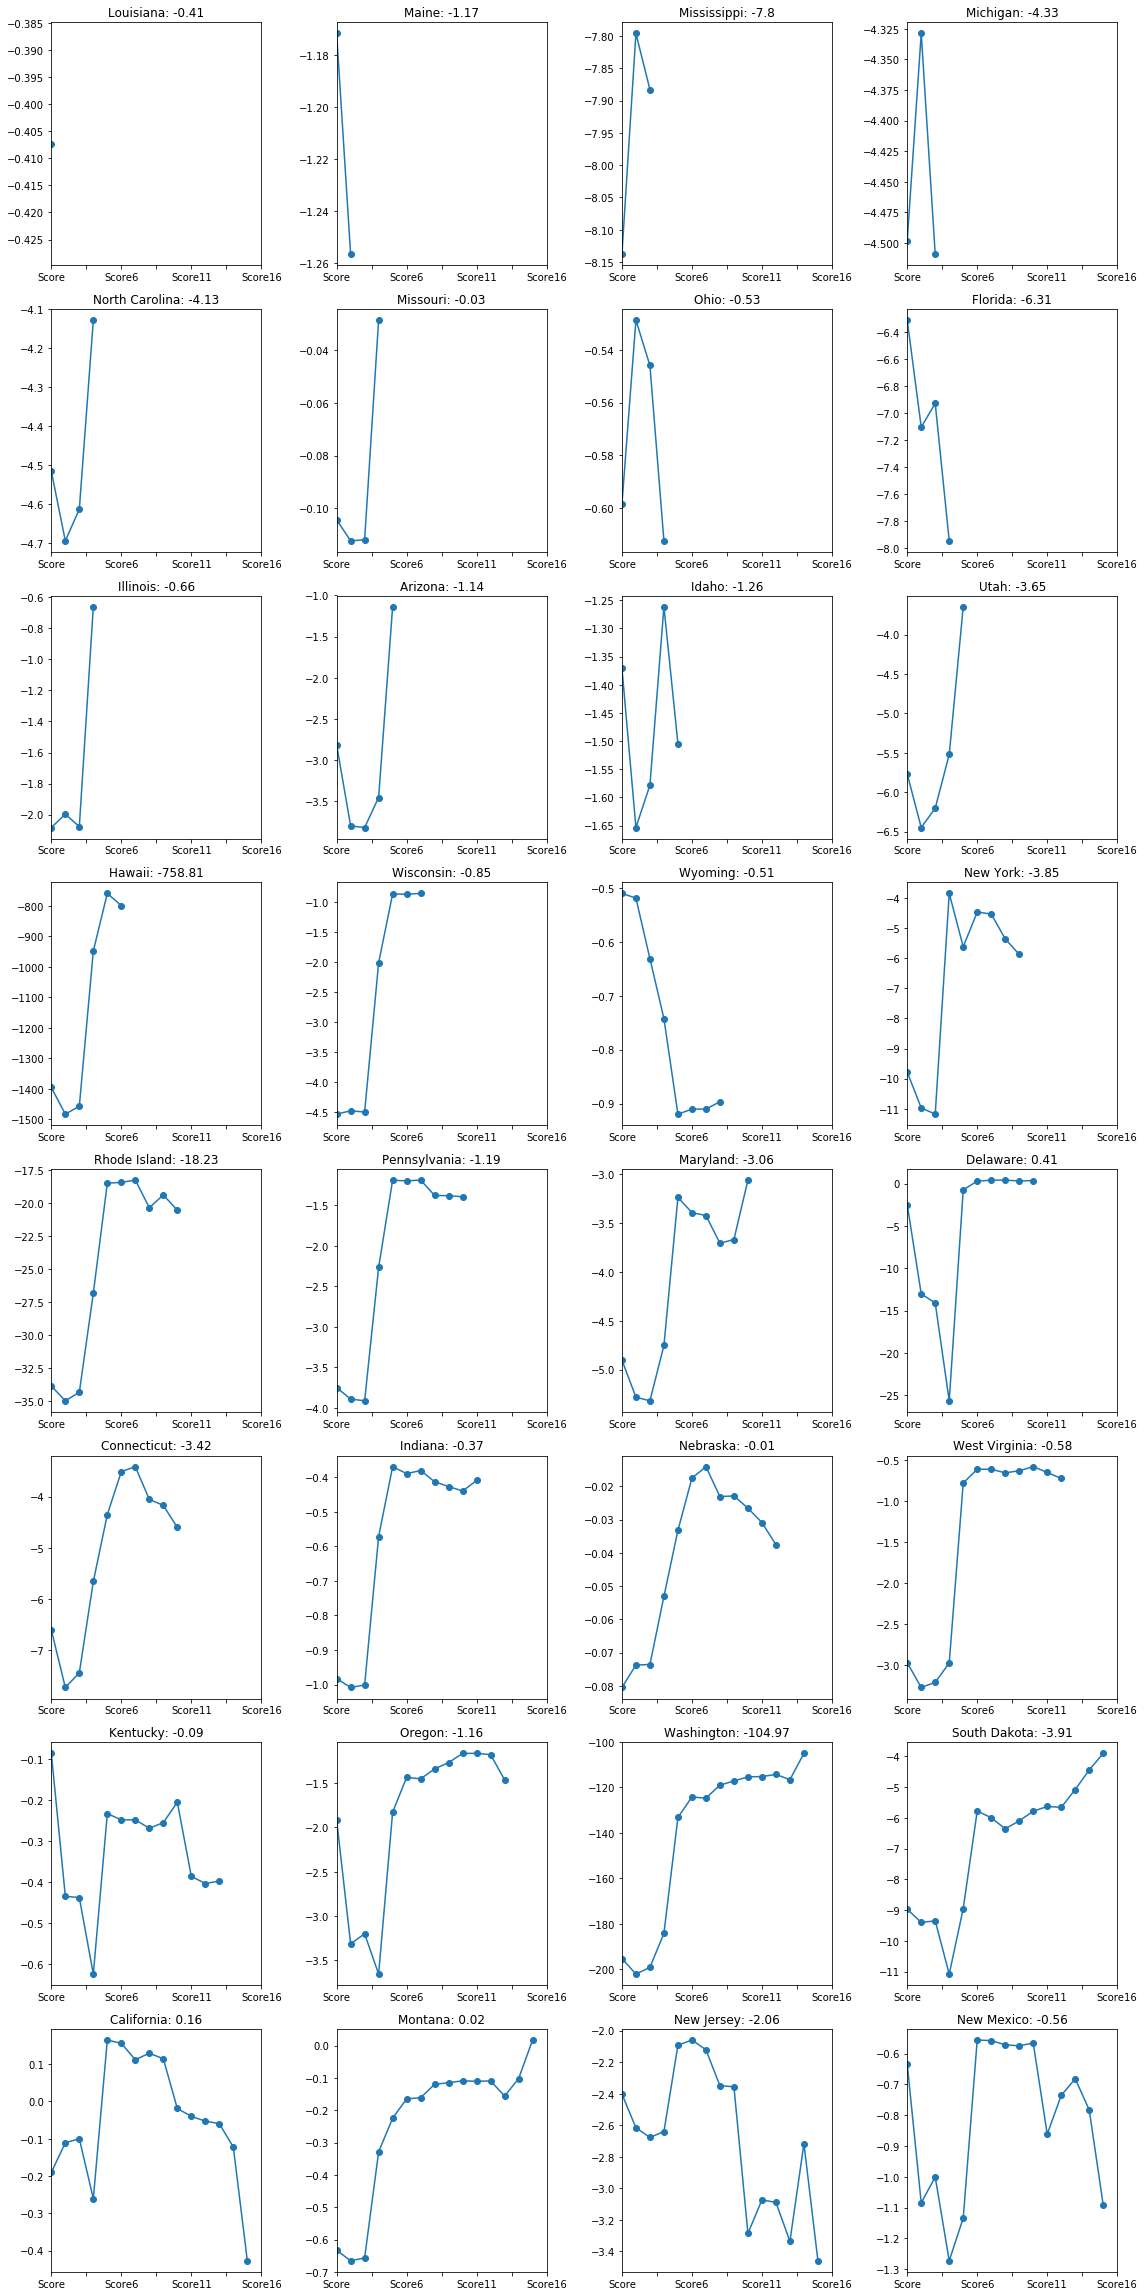

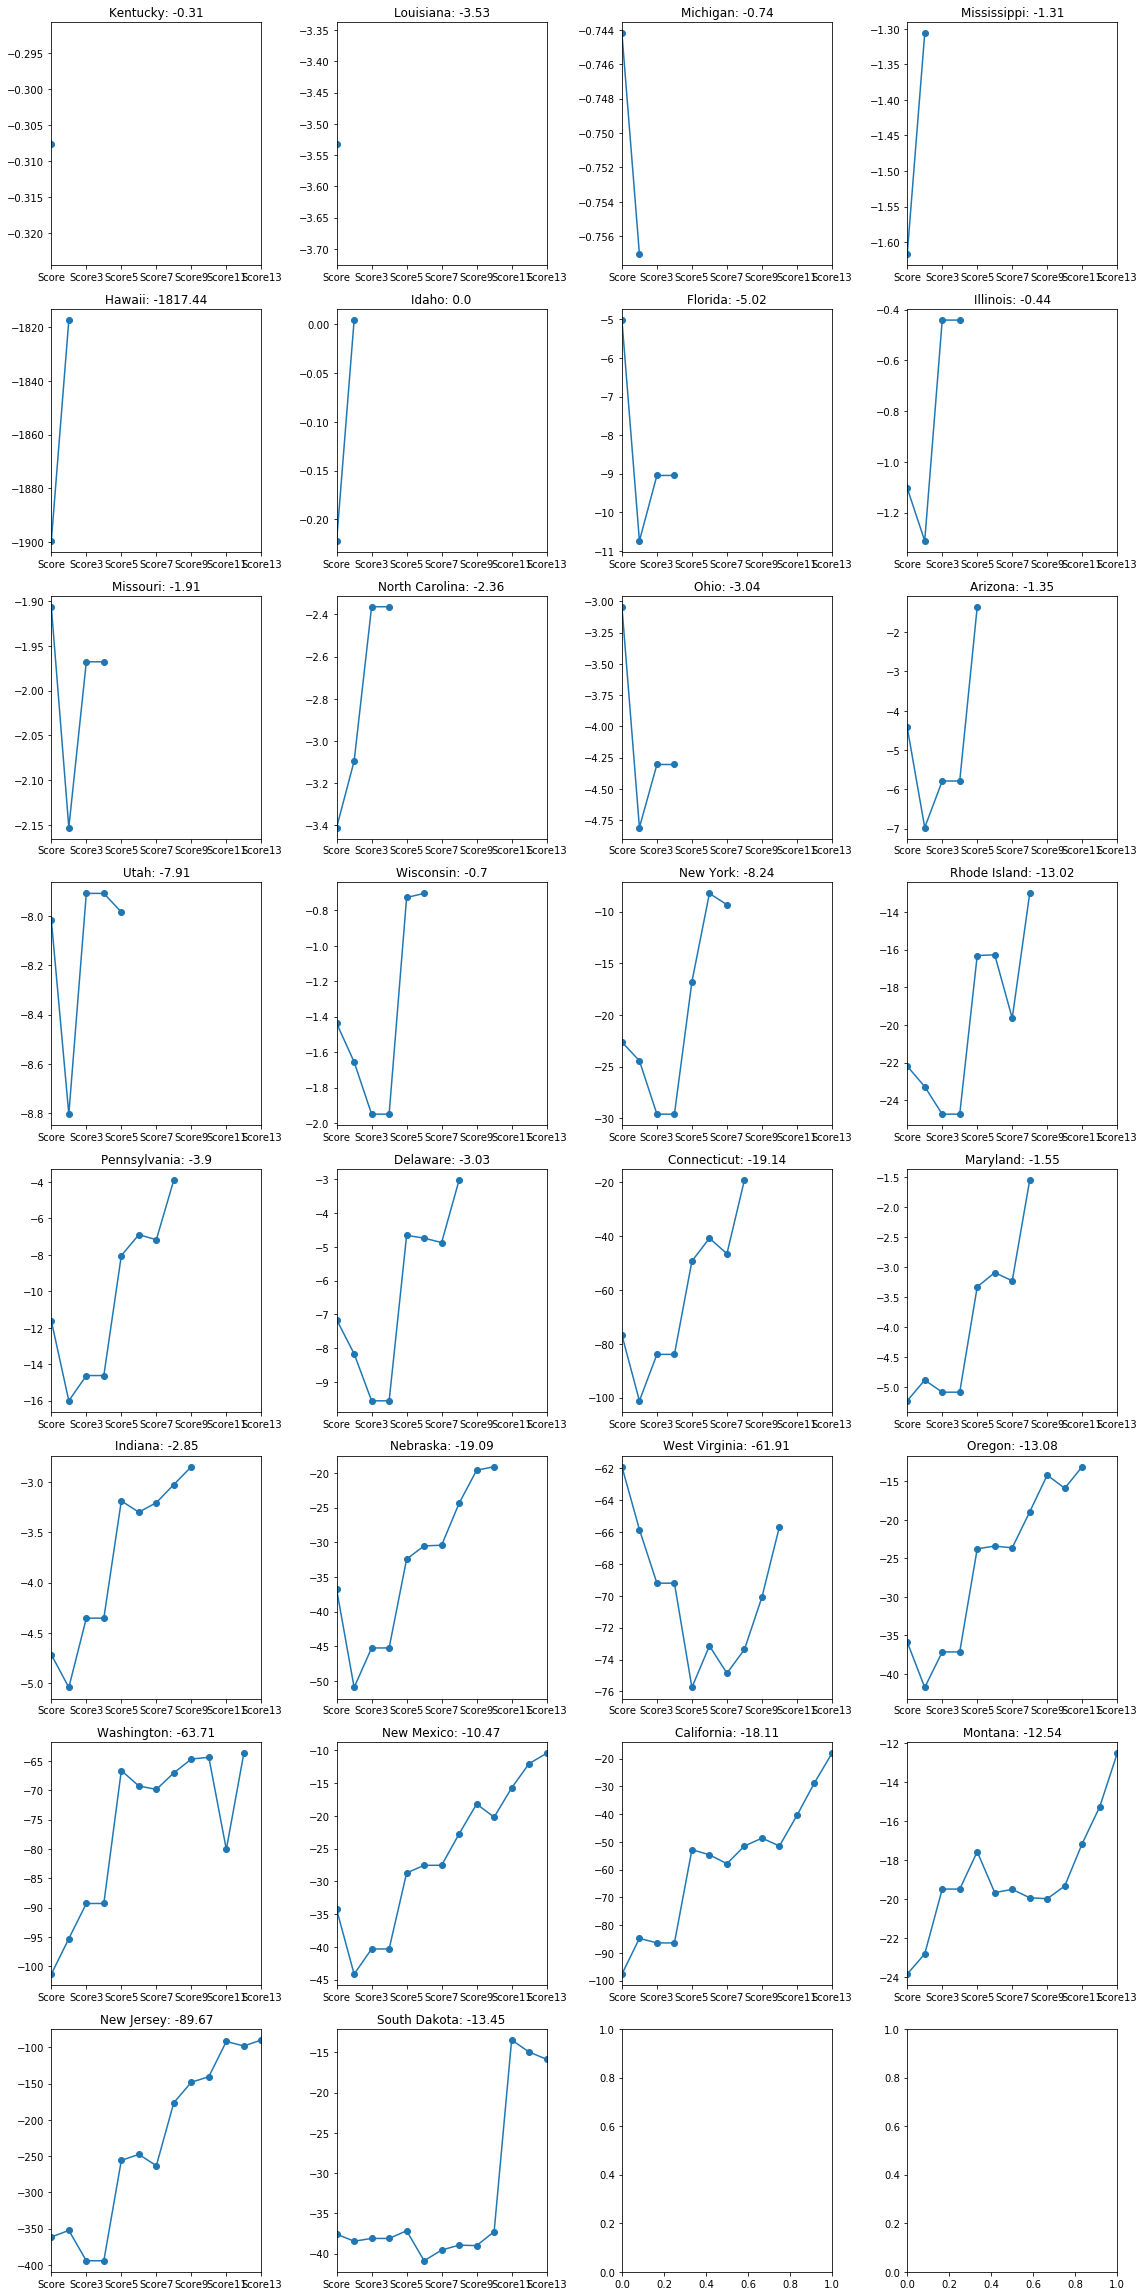

In [46]:
# Simple linear regression 1
MODEL = linear_model.Ridge(alpha = 0, normalize = True)
useOneModel(MODEL)

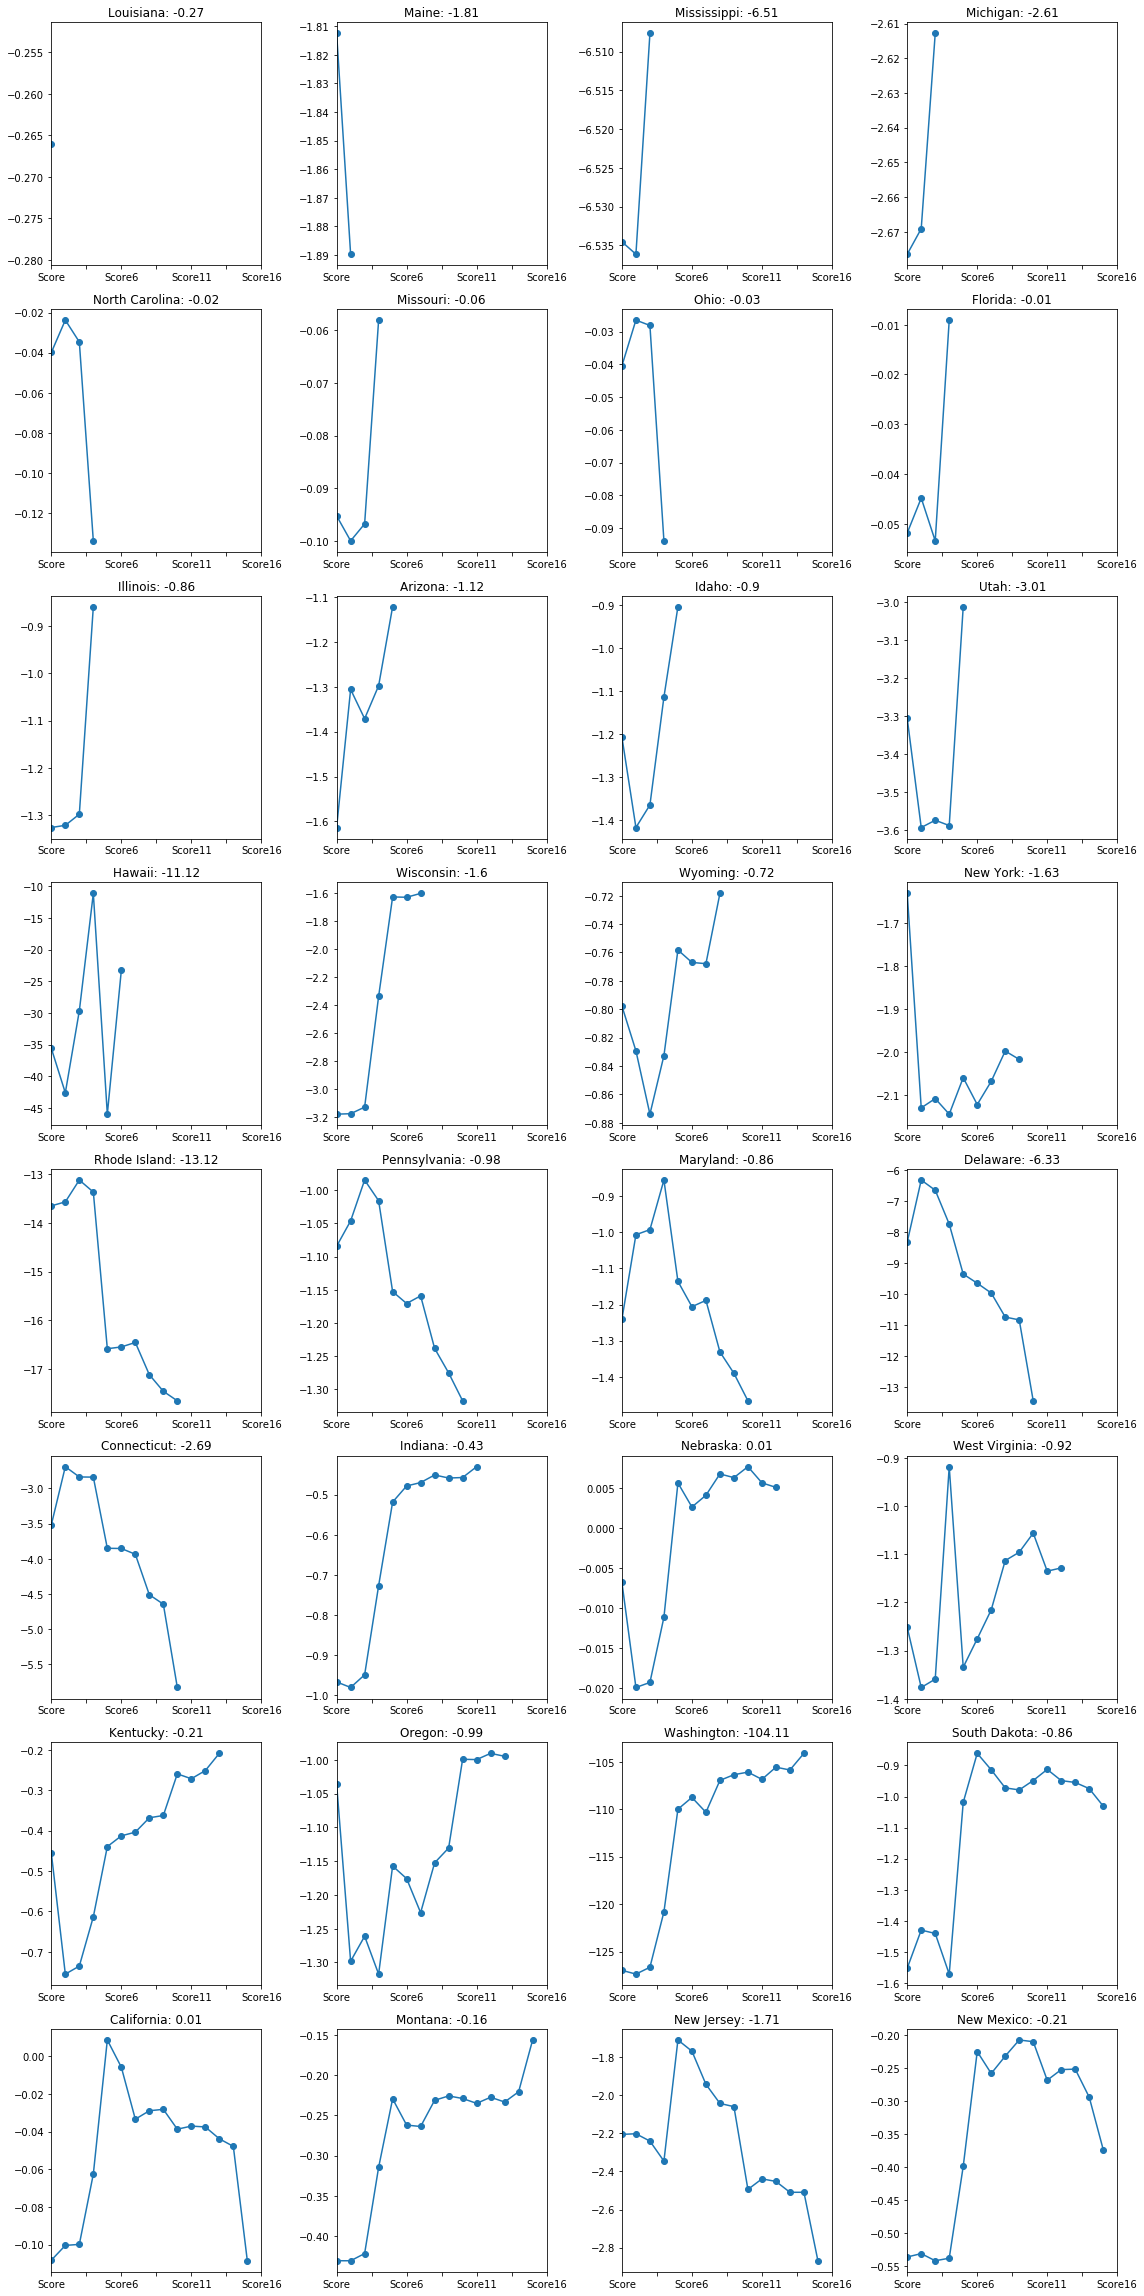

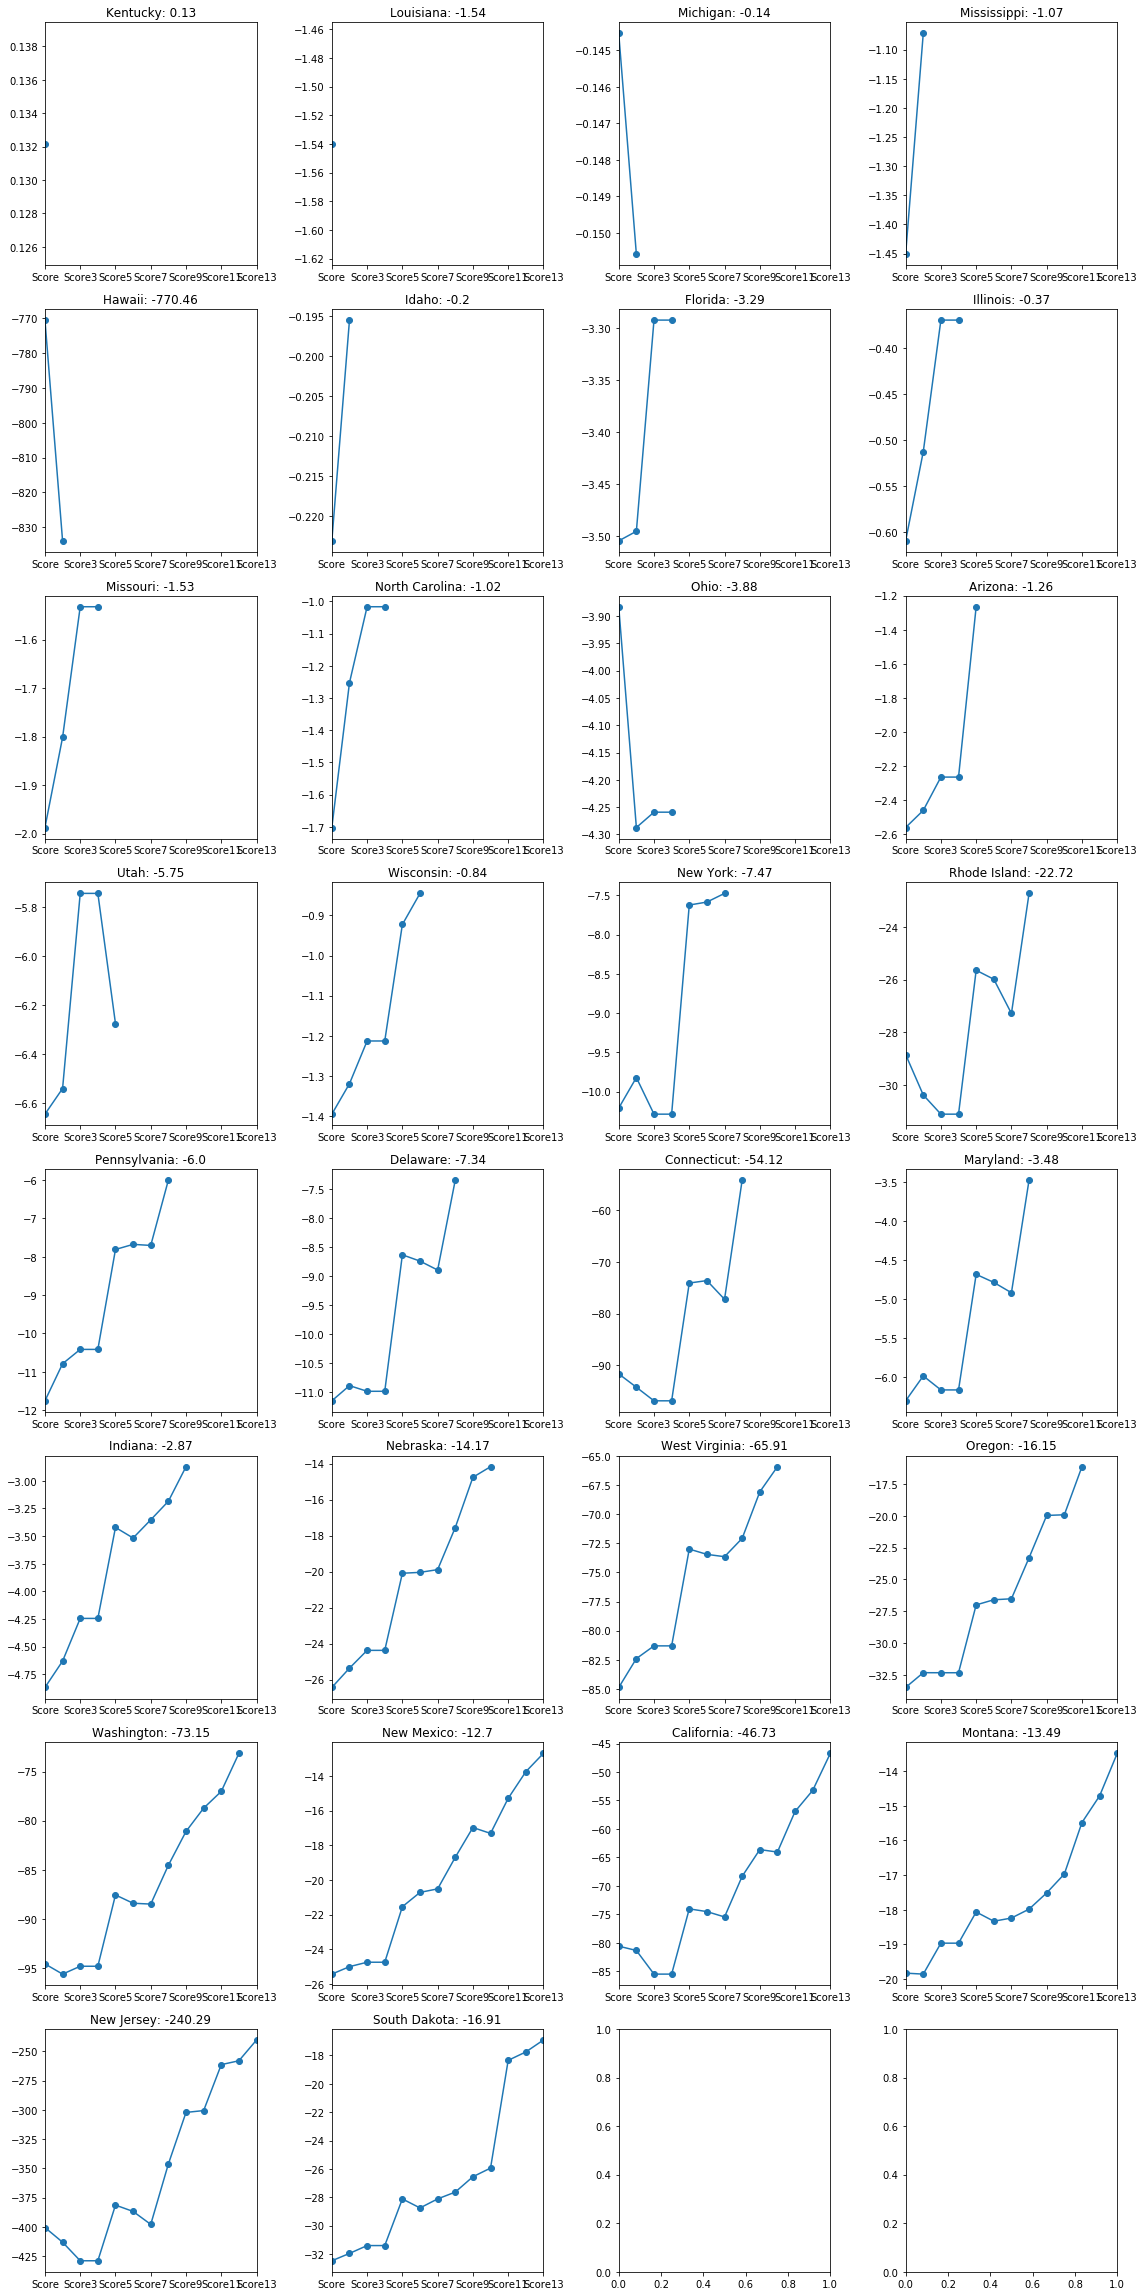

In [43]:
# Ridge regression with cross-validation
MODEL = linear_model.RidgeCV(alphas = [2.0**x for x in range(1,13)], normalize = True)
useOneModel(MODEL)

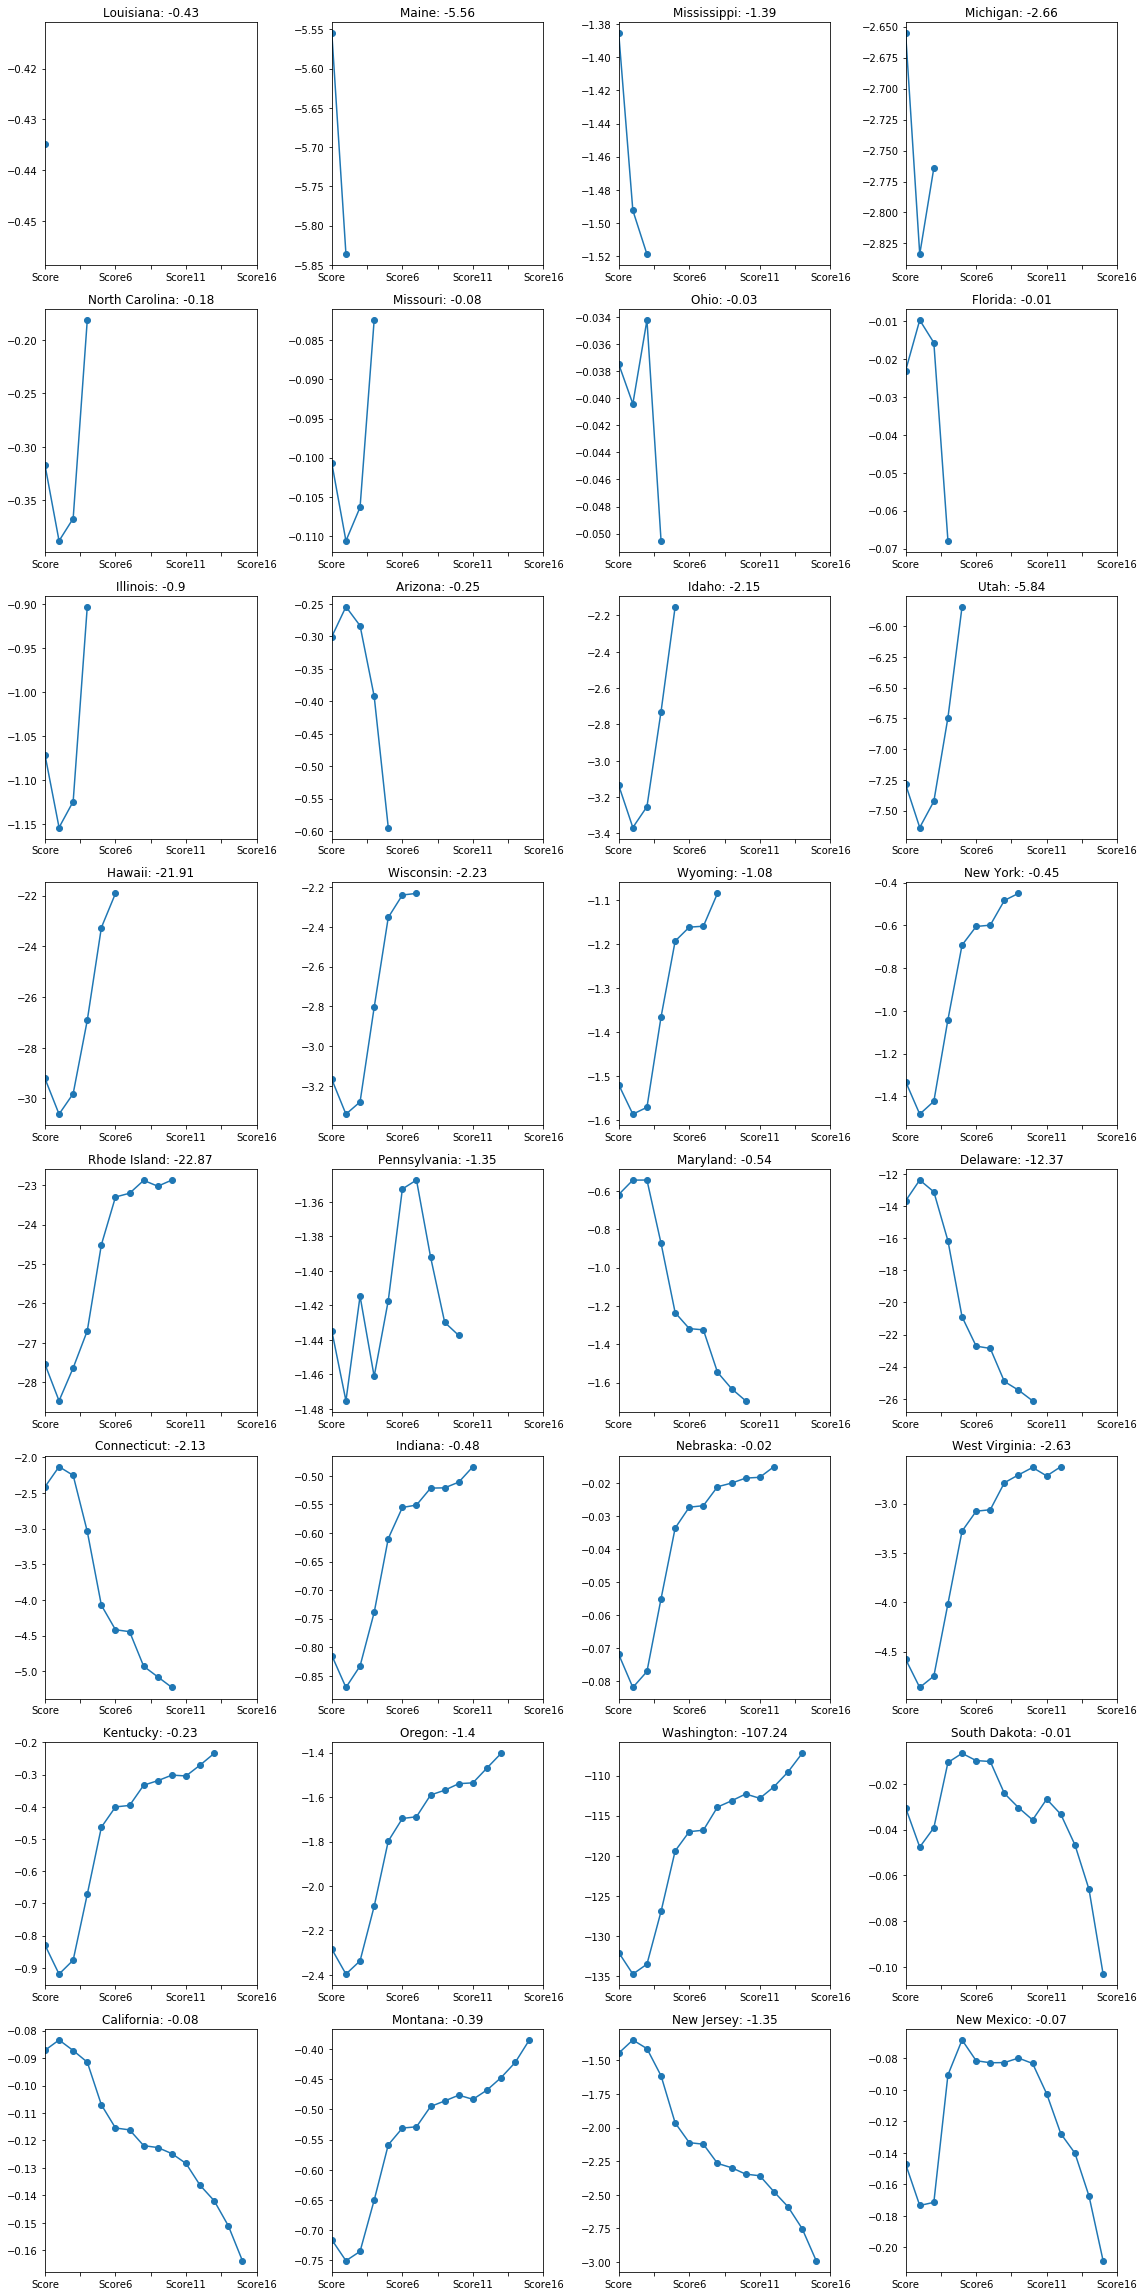

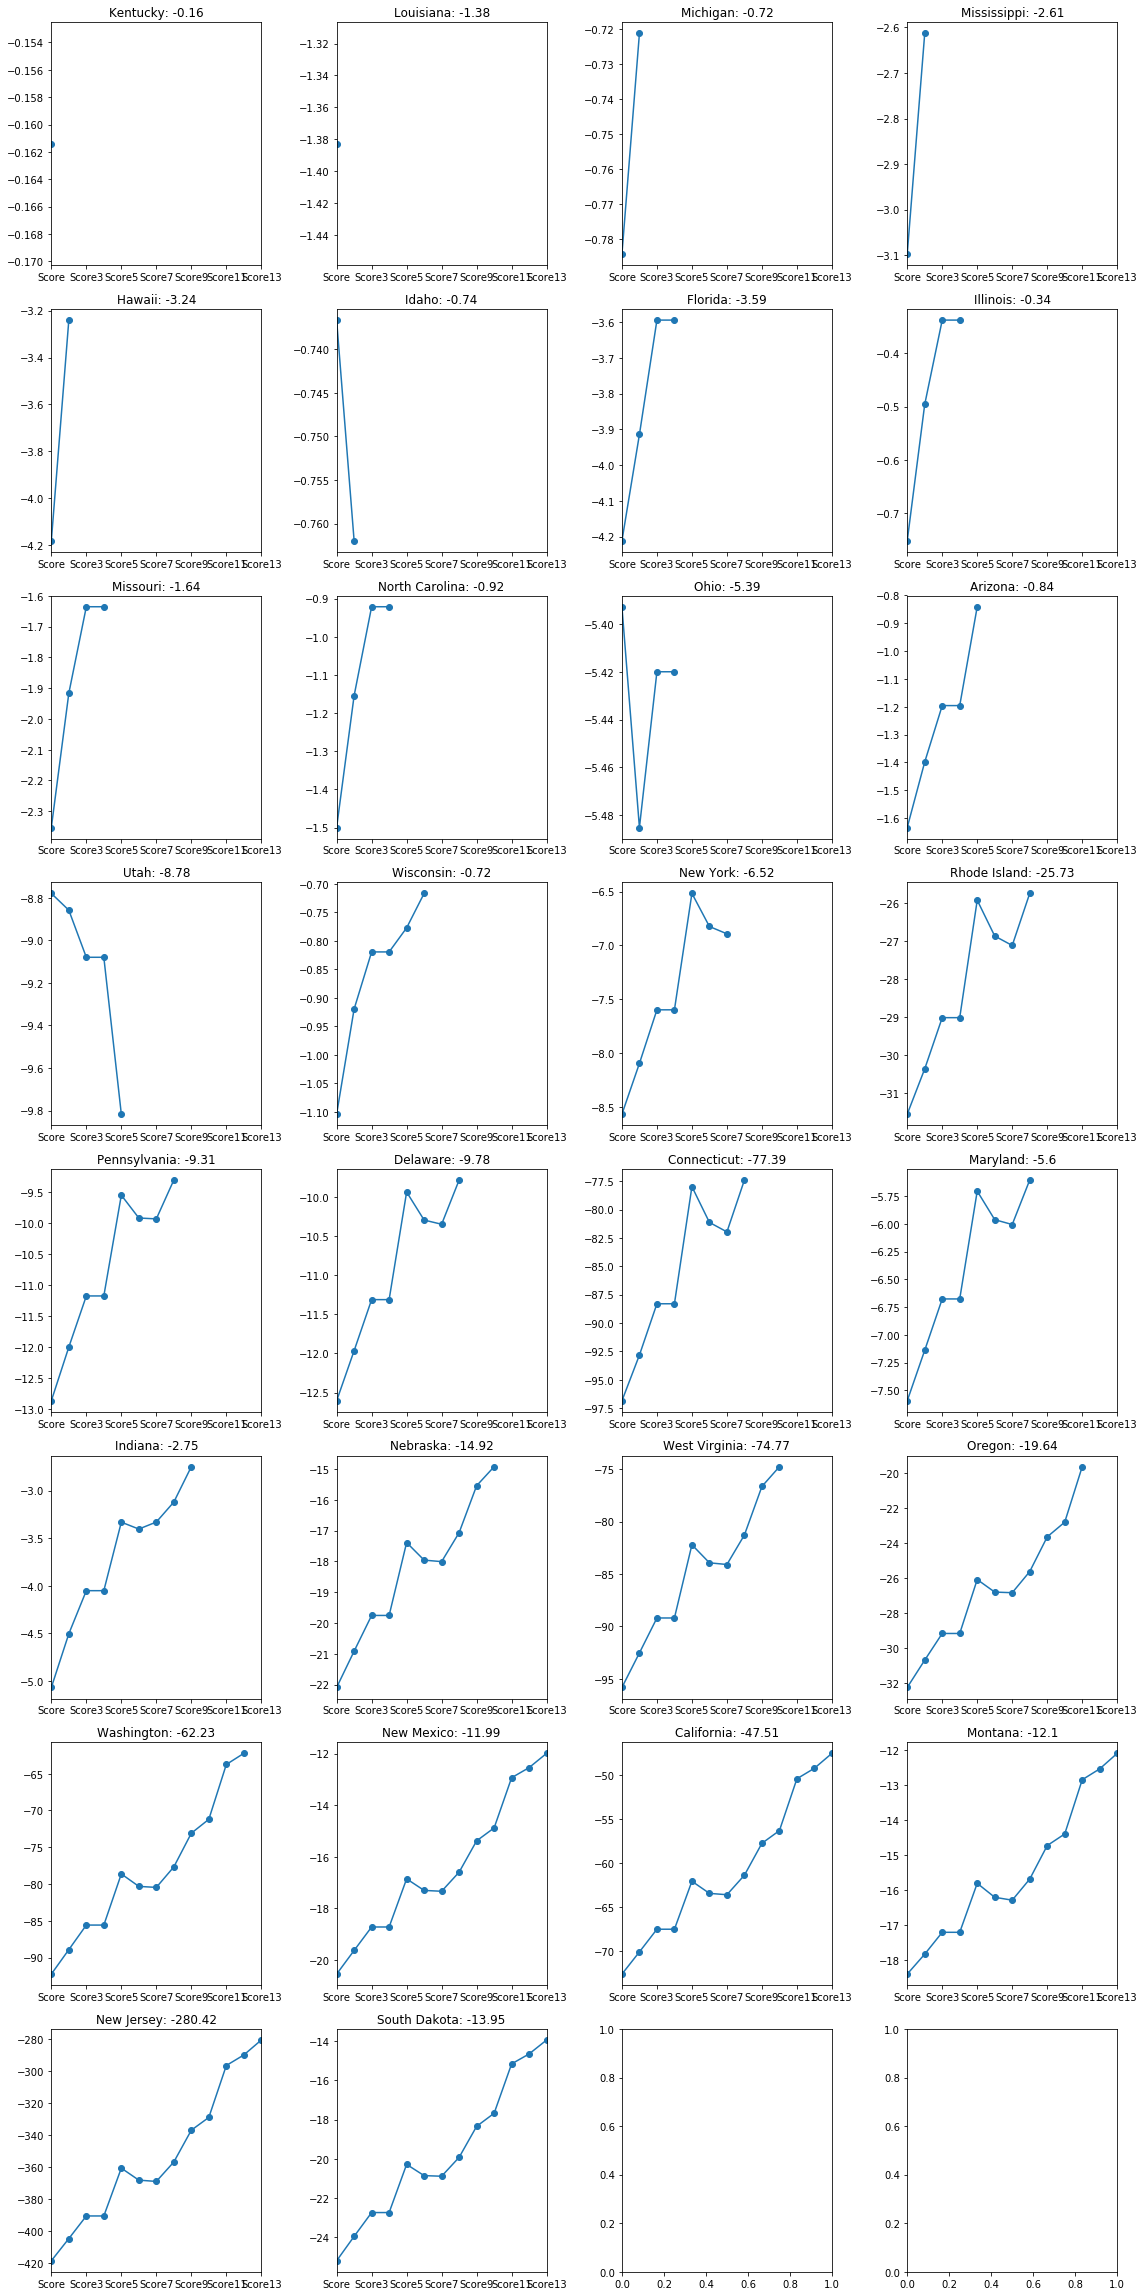

In [45]:
# Lasso regression with cross-validation
MODEL = linear_model.MultiTaskLassoCV(alphas = [2.0**x for x in range(1,13)], normalize = True)
useOneModel(MODEL)

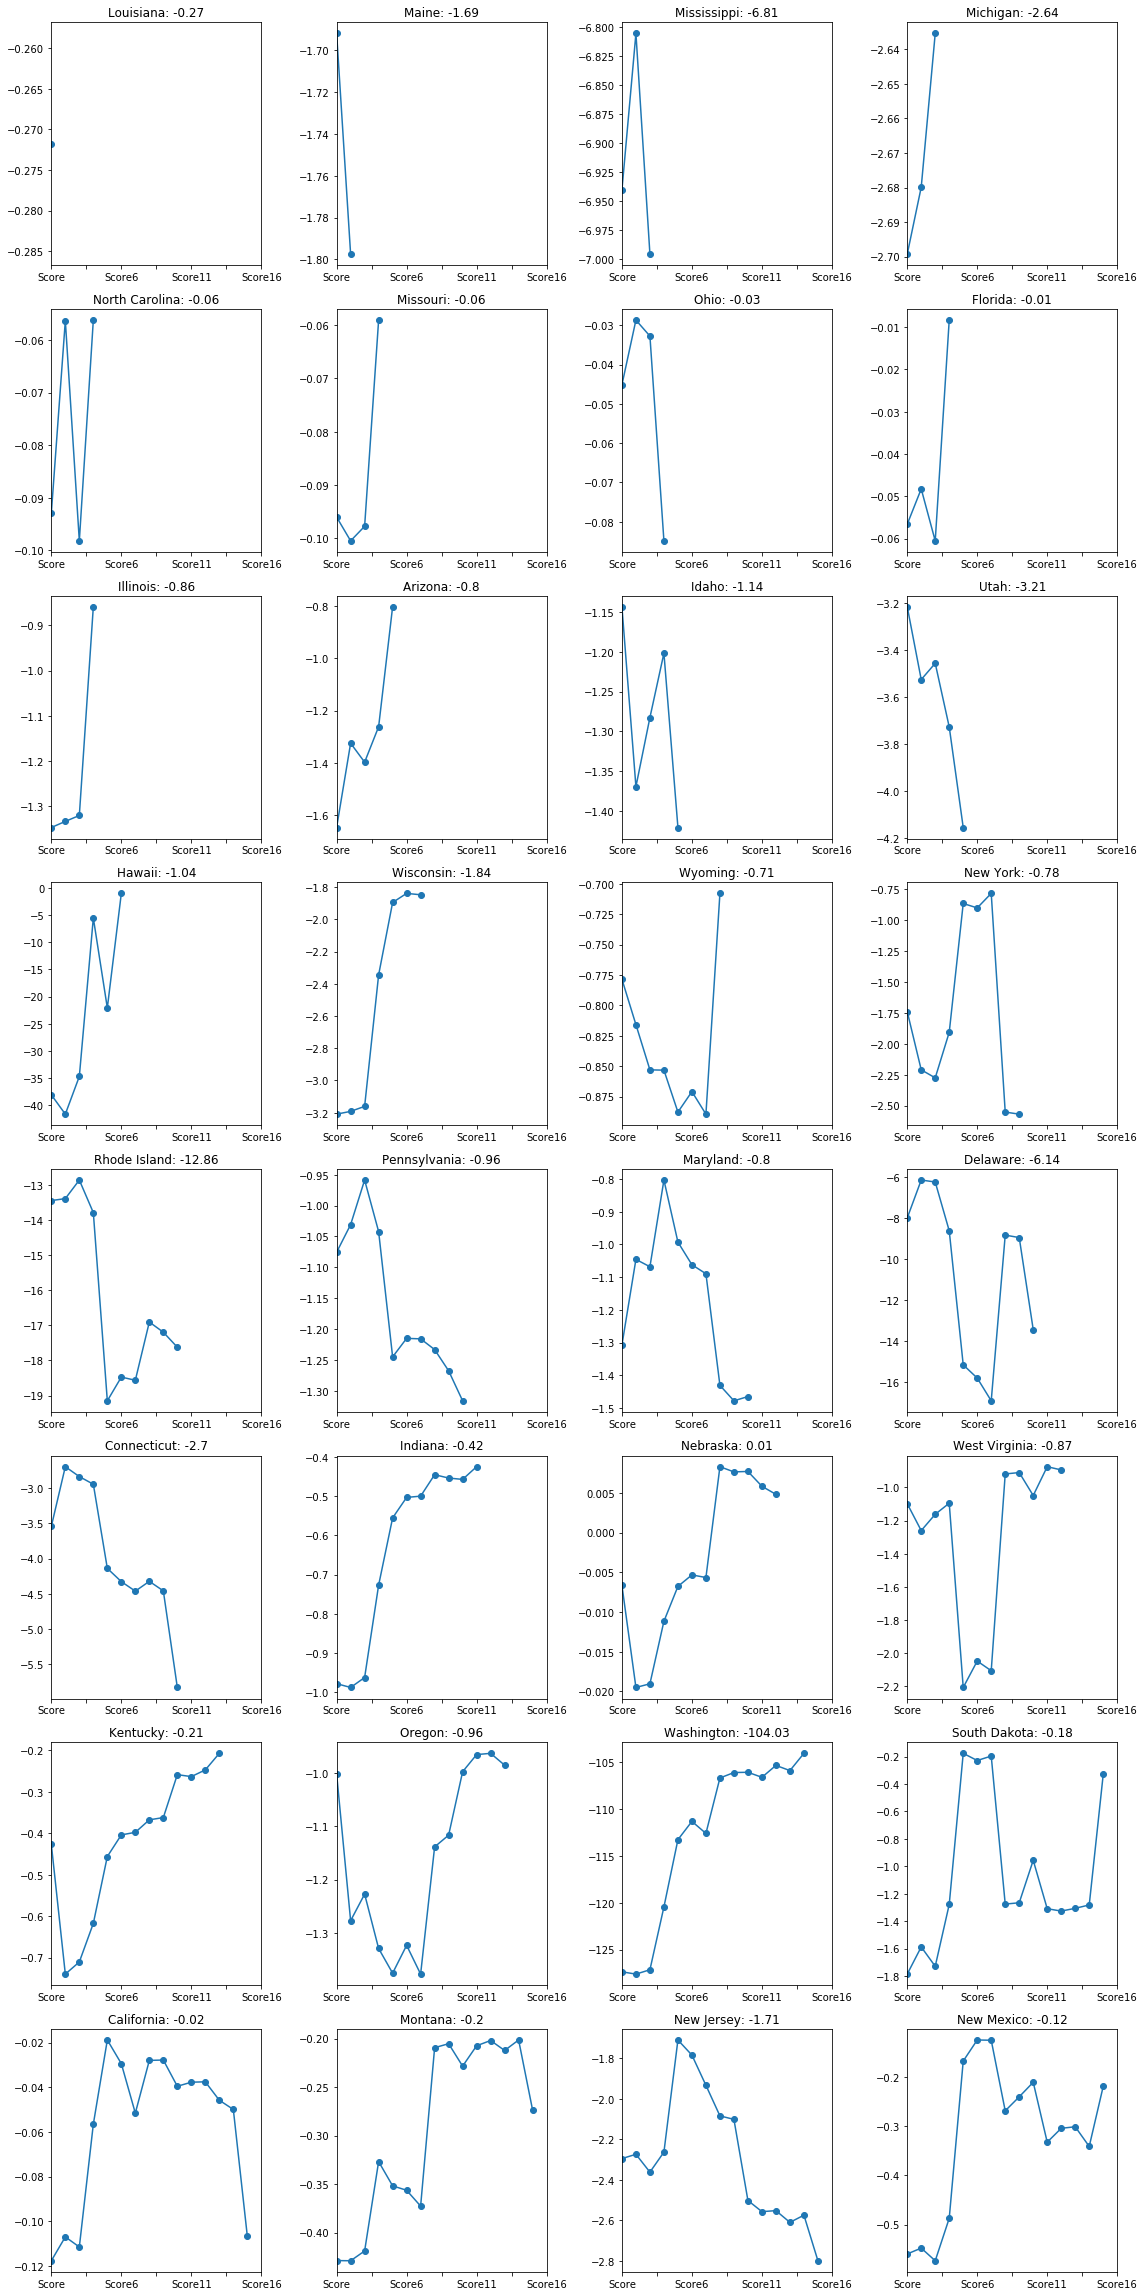

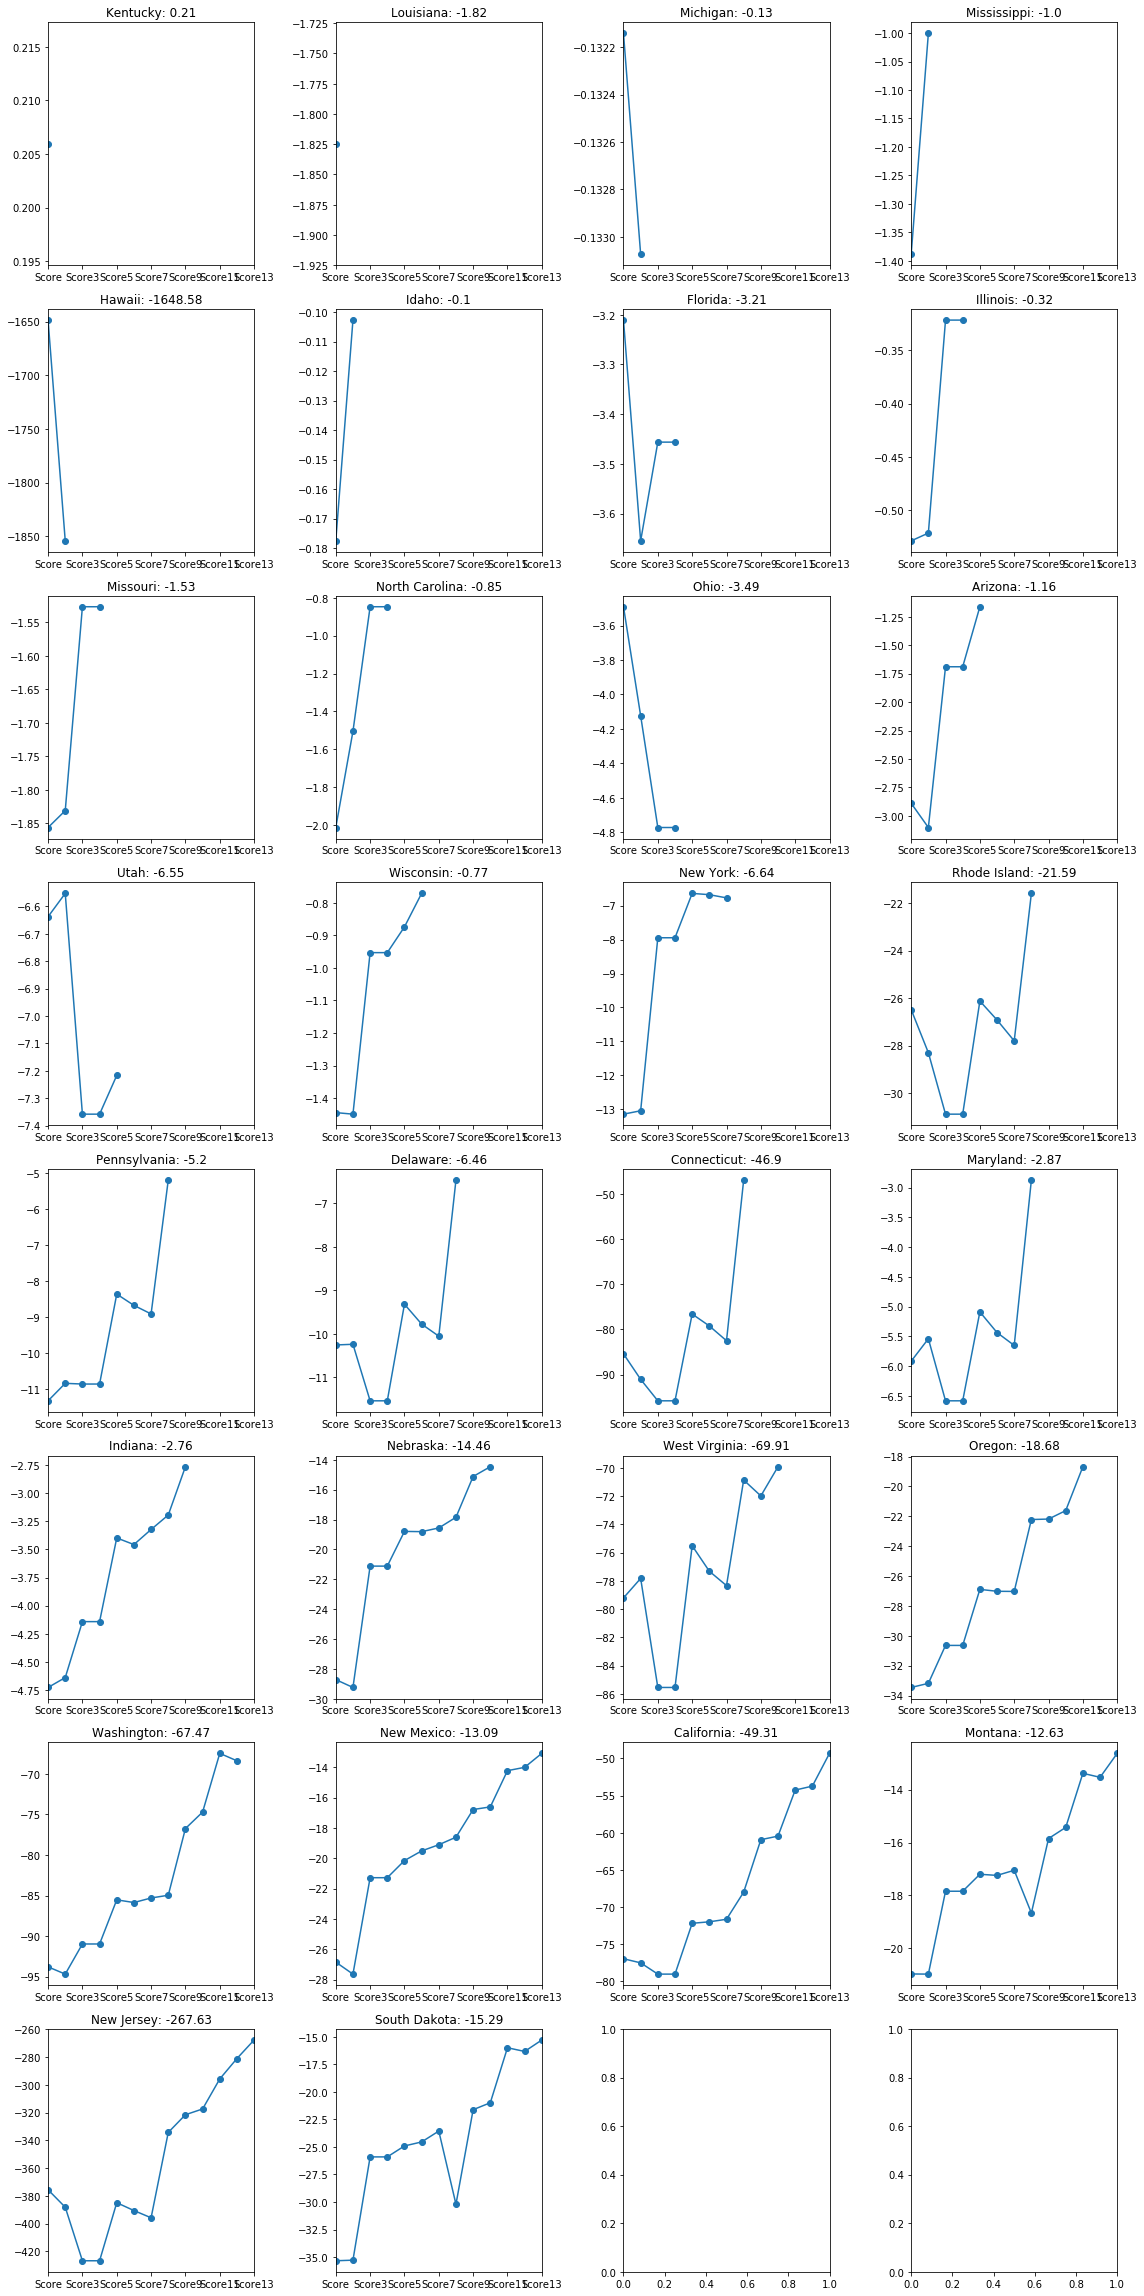

In [10]:
# Elastic Net regression with cross-validation
MODEL = linear_model.MultiTaskElasticNetCV(l1_ratio = np.arange(0.05, 1.0)/20.0, n_alphas = 100, normalize = True)
useOneModel(MODEL)

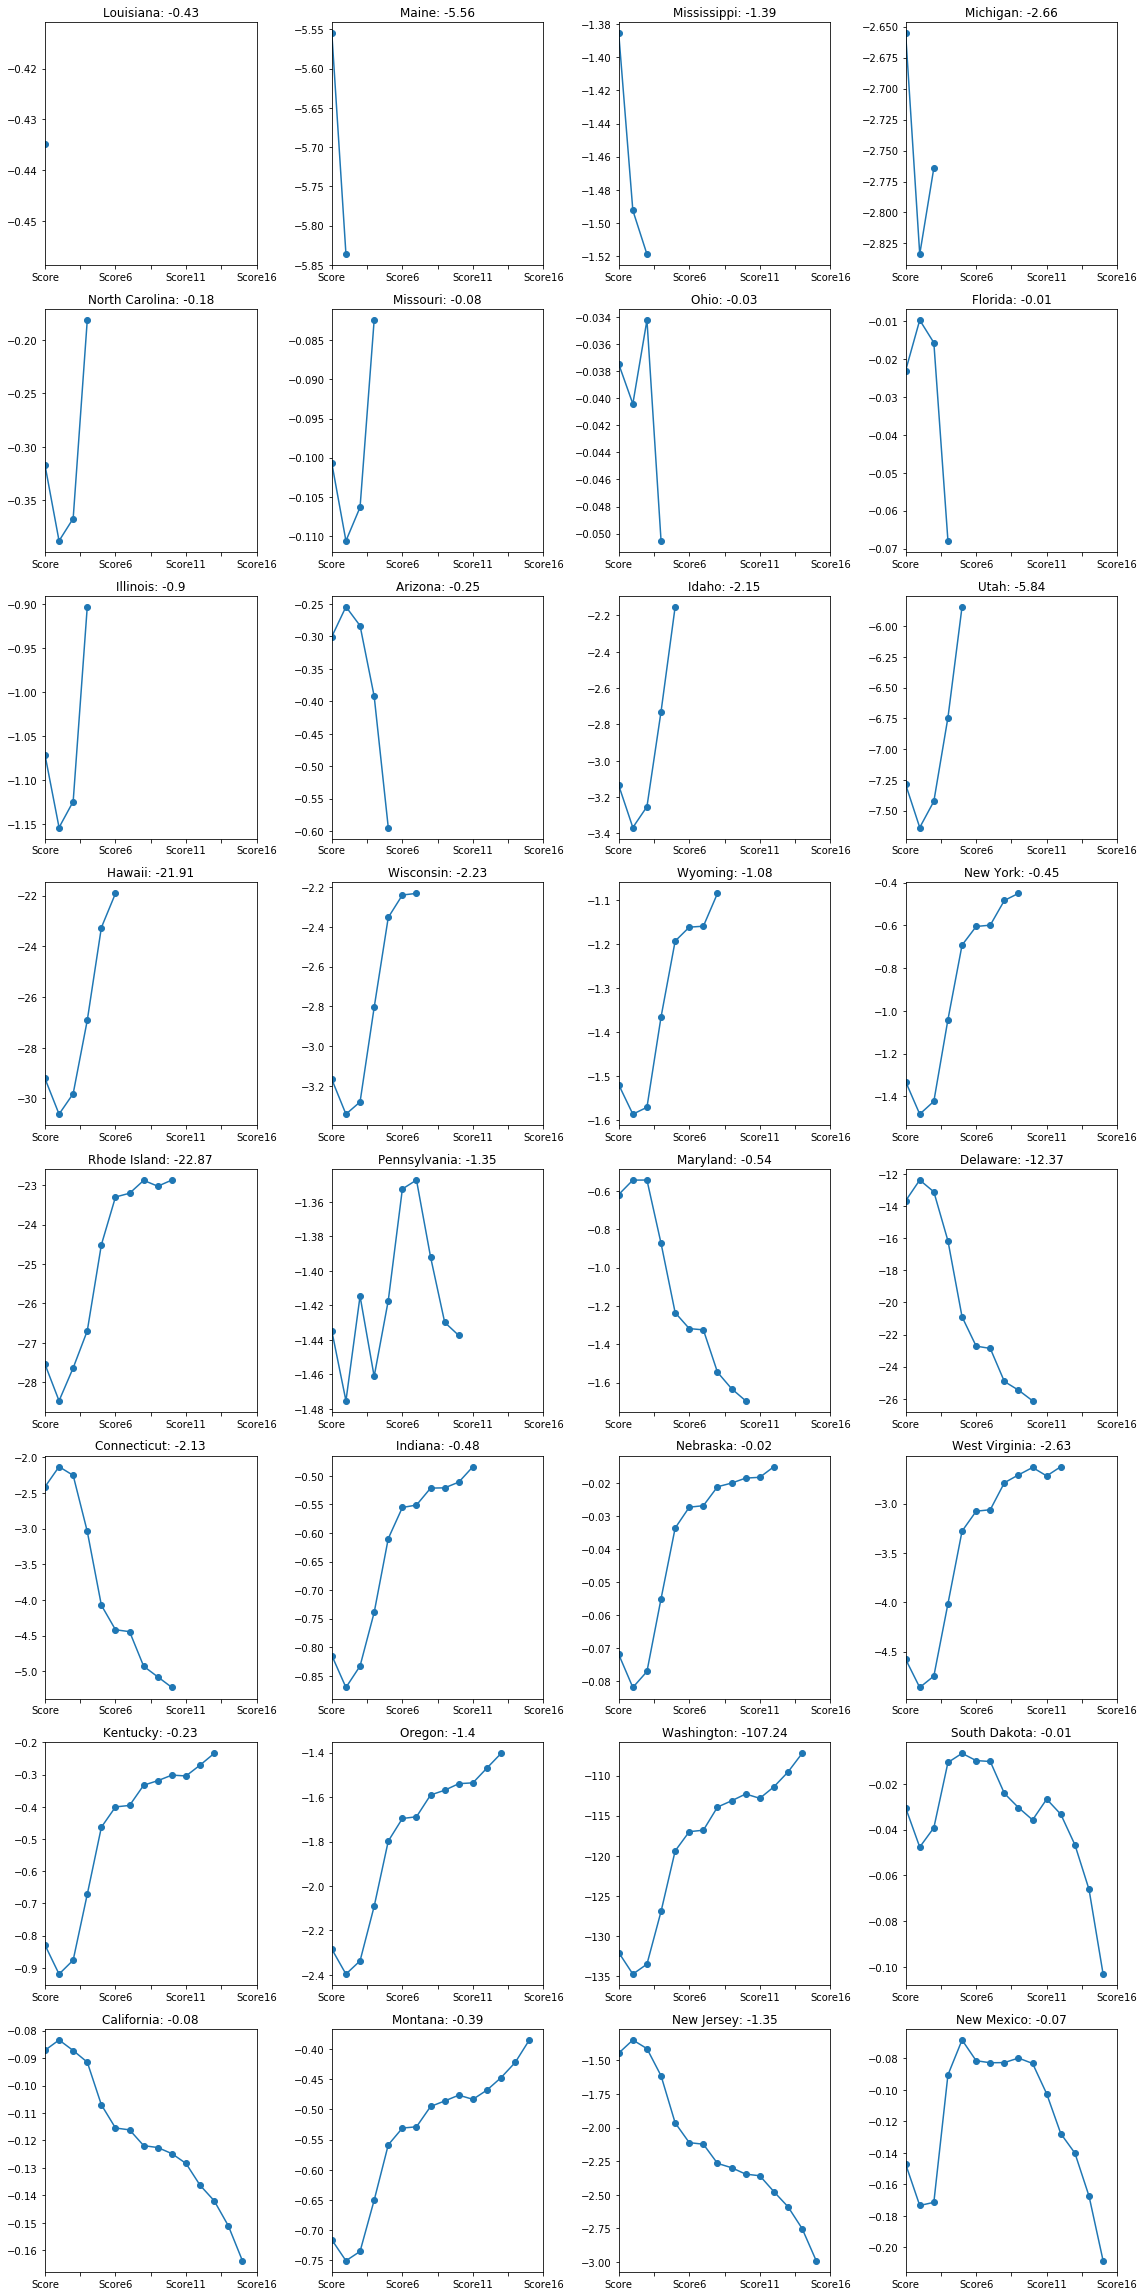

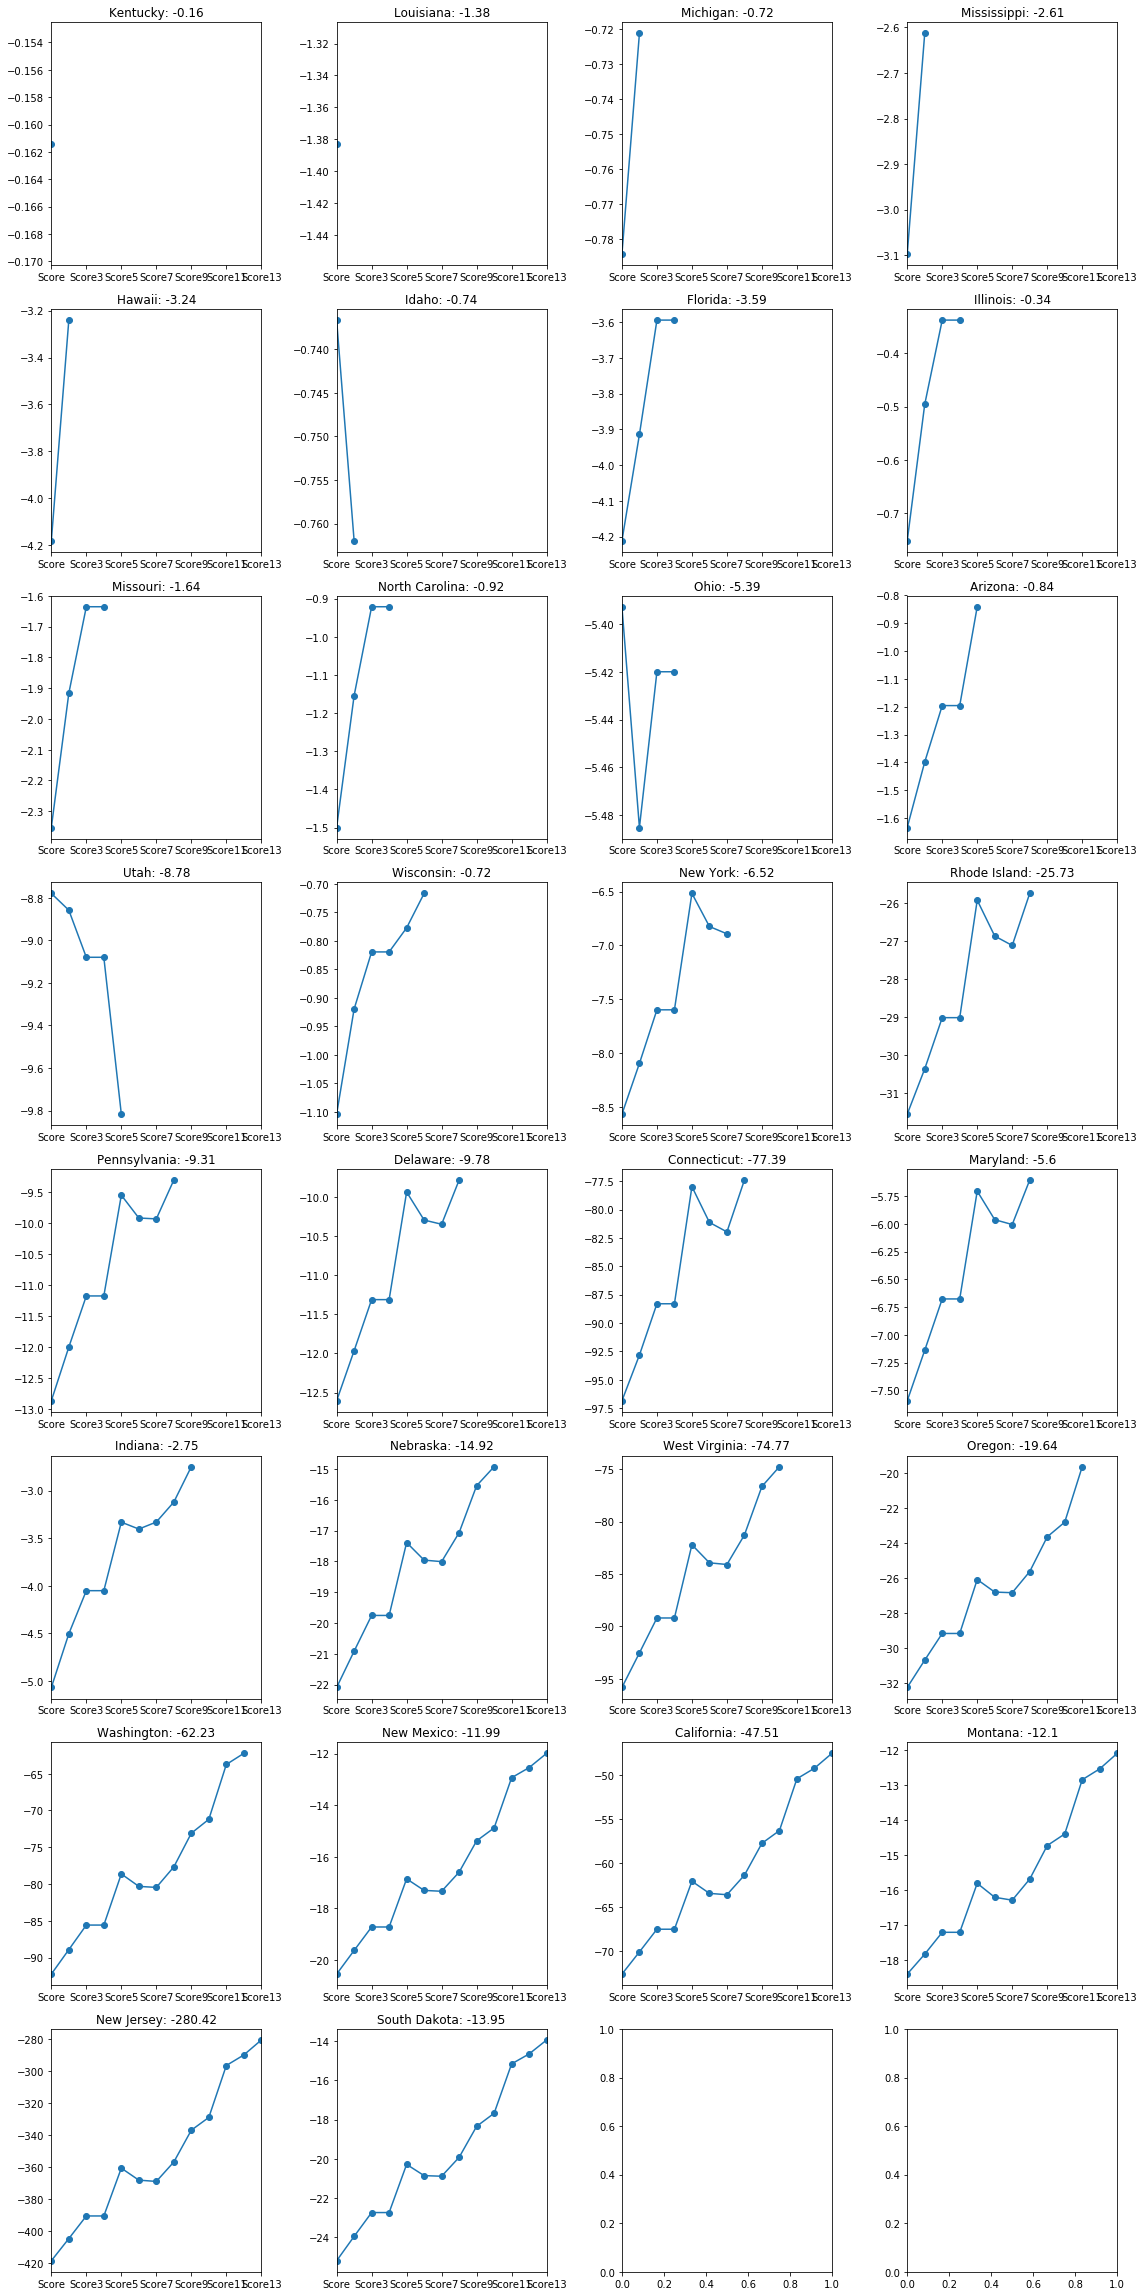

In [11]:
# Gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
MODEL = GaussianProcessRegressor(normalize_y = True)
useOneModel(MODEL)